In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("Using CPU")


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 2060 SUPER


In [3]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [11]:
import torch
import torch.nn.functional as F
from scipy.spatial import KDTree
import numpy as np

def gaussian_kernel(sigma, device):
    """Create 2D Gaussian kernel as a torch tensor."""
    size = int(6*sigma + 1)
    if size % 2 == 0:
        size += 1
    x = torch.arange(size, dtype=torch.float32, device=device) - size // 2
    x = x.repeat(size, 1)
    y = x.t()
    kernel = torch.exp(-(x**2 + y**2) / (2*sigma*sigma))
    kernel /= kernel.sum()
    return kernel.unsqueeze(0).unsqueeze(0)  # [1,1,H,W] for conv2d

def gaussian_filter_density_torch(gt, device="cuda"):
    """Generate density map on GPU using PyTorch."""
    gt_tensor = torch.from_numpy(gt).float().to(device)
    density = torch.zeros_like(gt_tensor)

    # find points (y, x)
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    gt_count = len(pts)
    if gt_count == 0:
        return density.cpu().numpy()

    # KDTree still on CPU (for distance-based sigma)
    tree = KDTree(pts.copy(), leafsize=2048)
    distances, _ = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = torch.zeros_like(gt_tensor)
        pt2d[pt[1], pt[0]] = 1.0

        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape)) / 4.0

        kernel = gaussian_kernel(sigma, device)
        # Apply Gaussian filter with conv2d
        pt2d = pt2d.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
        filtered = F.conv2d(pt2d, kernel, padding=kernel.shape[-1]//2)
        density += filtered.squeeze()

    return density.cpu().numpy()


In [5]:
#set the root to the Shanghai dataset you download
root = './shanghai/'

In [6]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [7]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [12]:
print('There are %d images in ShanghaiA train and test data.'%(len(img_paths)))
device = "cuda" if torch.cuda.is_available() else "cpu"

for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density_torch(k, device=device)

    # k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

There are 482 images in ShanghaiA train and test data.
./shanghai/part_A_final/train_data\images\IMG_1.jpg
./shanghai/part_A_final/train_data\images\IMG_10.jpg
./shanghai/part_A_final/train_data\images\IMG_100.jpg
./shanghai/part_A_final/train_data\images\IMG_101.jpg
./shanghai/part_A_final/train_data\images\IMG_102.jpg
./shanghai/part_A_final/train_data\images\IMG_103.jpg
./shanghai/part_A_final/train_data\images\IMG_104.jpg
./shanghai/part_A_final/train_data\images\IMG_105.jpg
./shanghai/part_A_final/train_data\images\IMG_106.jpg
./shanghai/part_A_final/train_data\images\IMG_107.jpg
./shanghai/part_A_final/train_data\images\IMG_108.jpg
./shanghai/part_A_final/train_data\images\IMG_109.jpg
./shanghai/part_A_final/train_data\images\IMG_11.jpg
./shanghai/part_A_final/train_data\images\IMG_110.jpg
./shanghai/part_A_final/train_data\images\IMG_111.jpg
./shanghai/part_A_final/train_data\images\IMG_112.jpg
./shanghai/part_A_final/train_data\images\IMG_113.jpg
./shanghai/part_A_final/train_d

In [9]:
torch.cuda.is_available()

True

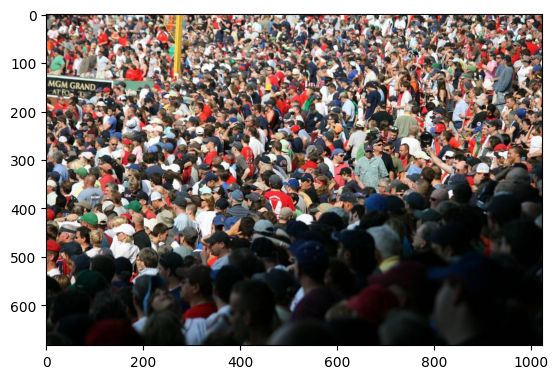

In [17]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[1]))

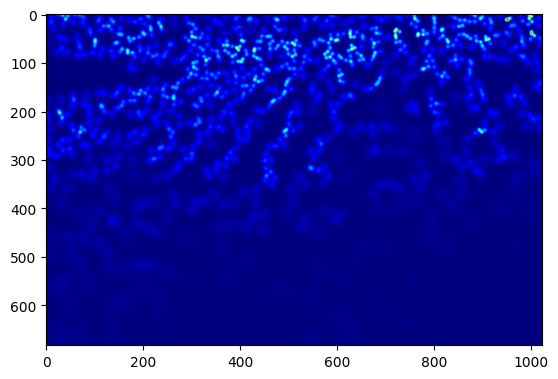

In [18]:
gt_file = h5py.File(img_paths[1].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [19]:
np.sum(groundtruth)# don't mind this slight variation

np.float32(904.2481)

In [20]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [21]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [22]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

./shanghai/part_B_final/train_data\images\IMG_1.jpg
./shanghai/part_B_final/train_data\images\IMG_10.jpg
./shanghai/part_B_final/train_data\images\IMG_100.jpg
./shanghai/part_B_final/train_data\images\IMG_101.jpg
./shanghai/part_B_final/train_data\images\IMG_102.jpg
./shanghai/part_B_final/train_data\images\IMG_103.jpg
./shanghai/part_B_final/train_data\images\IMG_104.jpg
./shanghai/part_B_final/train_data\images\IMG_105.jpg
./shanghai/part_B_final/train_data\images\IMG_106.jpg
./shanghai/part_B_final/train_data\images\IMG_107.jpg
./shanghai/part_B_final/train_data\images\IMG_108.jpg
./shanghai/part_B_final/train_data\images\IMG_109.jpg
./shanghai/part_B_final/train_data\images\IMG_11.jpg
./shanghai/part_B_final/train_data\images\IMG_110.jpg
./shanghai/part_B_final/train_data\images\IMG_111.jpg
./shanghai/part_B_final/train_data\images\IMG_112.jpg
./shanghai/part_B_final/train_data\images\IMG_113.jpg
./shanghai/part_B_final/train_data\images\IMG_114.jpg
./shanghai/part_B_final/train_da

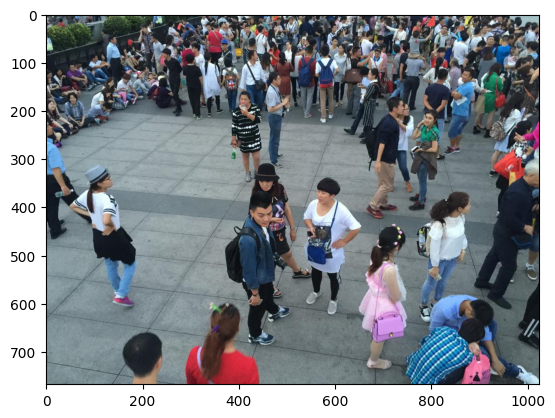

In [23]:
plt.imshow(Image.open(img_paths[1]))

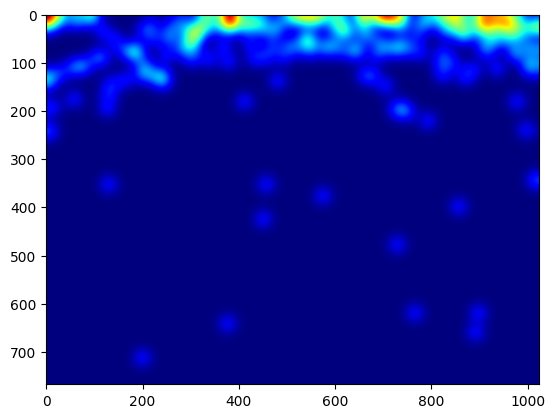

In [24]:
gt_file = h5py.File(img_paths[1].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)